In [1]:
import torch
from torchnmf.nmf import NMF
from torchnmf import metrics as mtx
import matplotlib.pyplot as plt
import tqdm 
import numpy as np
import os
import skimage.io as iio
from tqdm import tqdm

In [2]:
# load in some data to be factorized
path = '/home/nrt2124/engram/cuttlefish/CUTTLEFISH_BEHAVIOR/cuttle_data_storage/2024_Interesting_skin_compiled_dataset/Nice skin manual crops/Lightroom Export_full res/'
files = np.sort(os.listdir(path))
images = iio.ImageCollection(path + '/*.tif')
cuts = [1080, 720]
cut_0 = cuts[0]
cut_1 = cuts[1]

shapes = np.empty((3, len(images)))
for i, image in enumerate(tqdm(images)):
   for j in range(3):
      shapes[j,i] = image.shape[j]

mask_0 = shapes[0,:] > cut_0
mask_1 = shapes[1,:] > cut_1

index_mask0 = np.where(mask_0 == True)[0]
index_mask1 = np.where(mask_1 == True)[0]

full_mask = np.intersect1d(index_mask0, index_mask1)

#first filter out unusually small images
print(len(images))
images_cut = [images[i] for i in full_mask]
print(len(images_cut))
print(len(full_mask))

100%|██████████| 430/430 [00:09<00:00, 43.92it/s]


430
382
382


In [3]:
def crop_image_to_size(image, output_size):
    height, width, c = image.shape


    # Desired output size
    new_height, new_width = output_size


    # Calculate coordinates to crop at the center
    start_x = (width // 2) - (new_width // 2)
    start_y = (height // 2) - (new_height // 2)

    # Crop the image
    cropped_img = image[start_y:start_y+new_height, start_x:start_x+new_width]
    return cropped_img



cropped_ims  = []
for image_cut in tqdm(images_cut):
    cropped_ims.append(crop_image_to_size(image_cut, (cut_0, cut_1)))

100%|██████████| 382/382 [00:00<00:00, 313056.69it/s]


In [4]:
#reshape and convert to grayscale
cropped_ims_flipped = [np.max(cropped_im) - cropped_im for cropped_im in cropped_ims] #flip brighness values
cropped_ims = cropped_ims_flipped
dataset = np.asarray(cropped_ims)

# #grayscale data
gray_data = 0.2989*dataset[:,:,:,0] + 0.5870*dataset[:,:,:,1]+0.1140*dataset[:,:,:,2]

gray_data_flattened = gray_data.reshape(gray_data.shape[0], -1)
print(gray_data_flattened.shape) #382 flattend images :)

(382, 777600)


In [ ]:
#convert data for nmf
V = torch.tensor(gray_data_flattened).to(torch.float32)
print(V.shape)

#create and train base model:
rank = 300
model = NMF(V.shape, rank=rank)

#on gpu
V = V.cuda()
model = model.cuda()

model.fit(V, tol = 0.0000001, max_iter = 3000)

#return gpu resources
model = model.cpu()
V = V.cpu()

In [ ]:
#evaluate model:
W_m = model.W.detach()
H_m = model.H.detach()
print('W shape: ', W_m.shape, ' H shape: ', H_m.shape)
WH = W_m @ H_m.T
print('WH shape: ', WH.shape)
print('V shape: ', V.shape)

euc = mtx.euclidean(WH, V.T)
print(euc.item())

In [ ]:
#visualise features

# reshape to images
features_images = np.empty((H_m.shape[0], gray_data.shape[1], gray_data.shape[2])) #number of features, image shape
for i, factor in enumerate(W_m.T):
    features_images[i] = factor.reshape(gray_data.shape[1], gray_data.shape[2])

fig, axes = plt.subplots(2, 5, figsize=(15, 7), subplot_kw={'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes.ravel()):
    ax.imshow(features_images[i], cmap = 'viridis')
    ax.set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

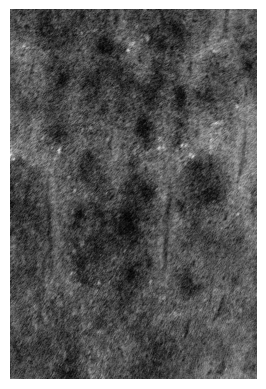

torch.Size([1, 777600])


In [9]:
#decompose a single image and see the reconstruction

gray_image = gray_data[4]
plt.imshow(gray_image, cmap = 'gray')
plt.axis('off')
plt.show()

flat_image = gray_image.reshape(1,-1)
flat_image = torch.tensor(flat_image)
print(flat_image.shape)

In [ ]:
V_new = flat_image.to(torch.float32)

#model for inference on a single image - uses the same W matrix as the original model
model_new = NMF(W=model.W.detach(), H=(V_new.shape[0], model.H.shape[1]), trainable_W=False)

#to the GPU
model_new.cuda()
V_new = V_new.cuda()

#inference
model_new.fit(V_new, tol = 0.0000001, max_iter = 2000)

#return the gpu
V_new = V_new.cpu()
model_new = model_new.cpu()

image_H = model_new.H


In [ ]:
reconstructed_image = image_H @ W_m.T
reshaped_image = reconstructed_image.reshape(gray_image.shape[0], gray_image.shape[1])

fig, ax = plt.subplots(1,2, subplot_kw={'xticks': (), 'yticks': ()})
ax[0].imshow(reshaped_image.detach().numpy(), cmap = 'gray')
ax[0].set_title('Reconstructed Image')
ax[1].imshow(gray_image, cmap = 'gray')
ax[1].set_title('Original Image')

plt.show()

In [ ]:
components = image_H
indicies = list(range(len(components[0])))
inx_components = list(zip(components[0], indicies))

sorted_components = sorted(inx_components, key=lambda x: x[0])
sorted_components.reverse()

In [ ]:
num_features = 20
idx = [sc[1] for sc in sorted_components[0:num_features]]

features = model_new.W.t()
image_components = features.reshape(features.shape[0], gray_image.shape[0], gray_image.shape[1])
image_components = image_components.detach().cpu().numpy()

top_features = image_components[idx]

fig, axes = plt.subplots(4, 5, figsize=(15, 7), subplot_kw={'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes.ravel()):
    ax.imshow(top_features[i], cmap = 'viridis')
    ax.set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

In [ ]:
#sparseness might be a good idea here... 
#and continuousness/contiguousness

#might need to implement from scratch to make this work

#invert image, so dark areas are bright!

In [33]:
#TO DO:

# Try out sparse factorisation, maybe features are sparse?
# Try to constrain this model further with a contiguousness metric

sparseness = None

In [34]:
#create and train sparse model:

#convert data for nmf
V = torch.tensor(gray_data_flattened).to(torch.float32)
print(V.shape)

rank = 382
sparse_model = NMF(V.shape, rank=rank)

#on gpu
V = V.cuda()
sparse_model = sparse_model.cuda()

sparse_model.sparse_fit(V, sW = sparseness)

#return gpu resources
sparse_model = sparse_model.cpu()
V = V.cpu()

torch.Size([382, 777600])


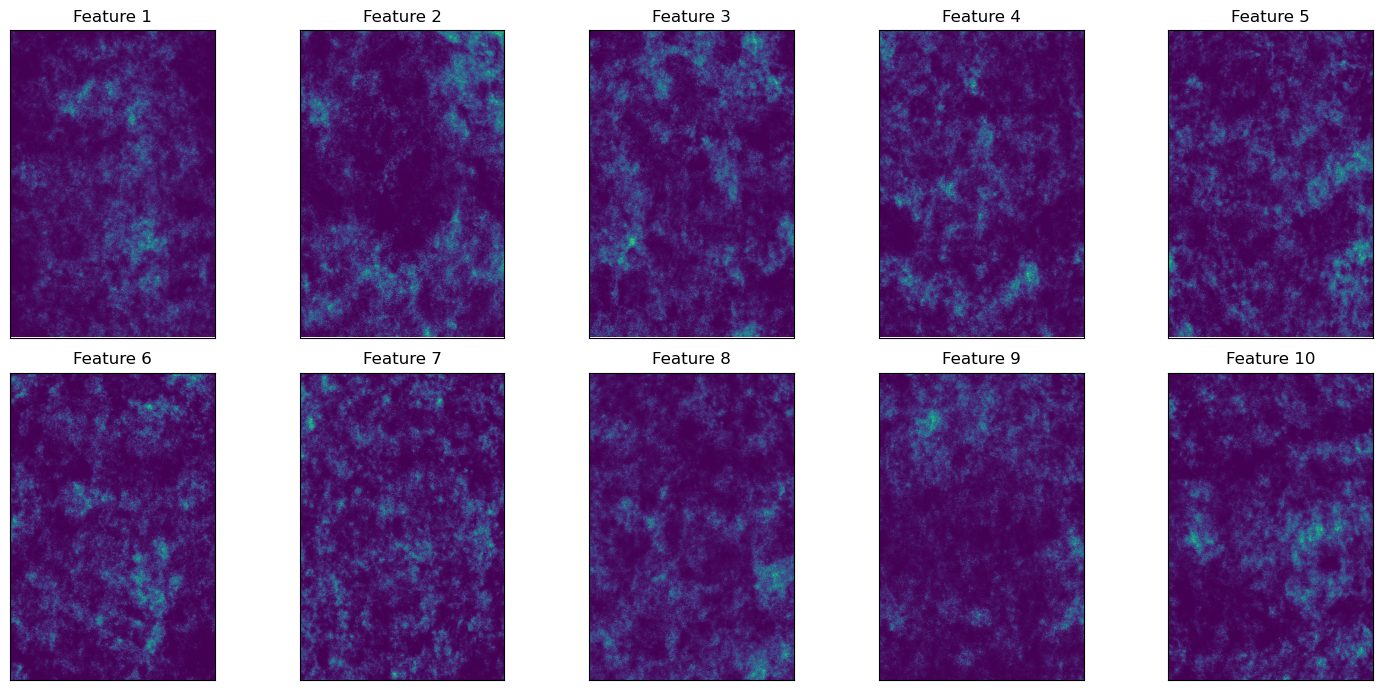

In [35]:
# visualise new features

sparse_H = sparse_model.H.detach()
sparse_W = sparse_model.W.detach()

# reshape to images
features_images = np.empty((sparse_H.shape[1], gray_data.shape[1], gray_data.shape[2])) #number of features, image shape
for i, factor in enumerate(sparse_W.T):
    features_images[i] = factor.reshape(gray_data.shape[1], gray_data.shape[2])

fig, axes = plt.subplots(2, 5, figsize=(15, 7), subplot_kw={'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes.ravel()):
    ax.imshow(features_images[i], cmap = 'viridis')
    ax.set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()


In [36]:
#single image sparse factors:

V_new = flat_image.to(torch.float32)

#model for inference on a single image - uses the same W matrix as the original model
model_new_sparse = NMF(W=sparse_model.W.detach(), H=(V_new.shape[0], sparse_model.H.shape[1]), trainable_W=False)

#to the GPU
model_new_sparse.cuda()
V_new = V_new.cuda()

#inference
model_new_sparse.sparse_fit(V_new, sW = sparseness) #here is the bug, need to set sparseness constrinats in this func. Also need to start reading docs better! :)

#return the gpu
V_new = V_new.cpu()
model_new_sparse = model_new_sparse.cpu()

image_H = model_new_sparse.H

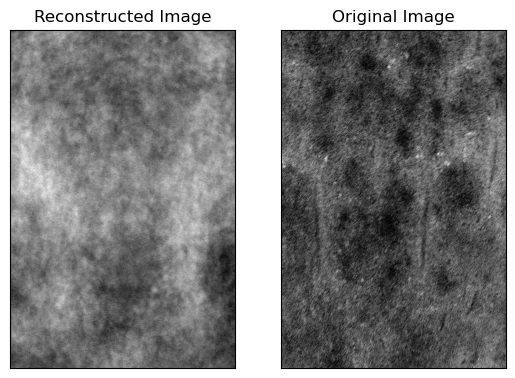

In [37]:
reconstructed_image = image_H @ sparse_model.W.T
reshaped_image = reconstructed_image.reshape(gray_image.shape[0], gray_image.shape[1])

fig, ax = plt.subplots(1,2, subplot_kw={'xticks': (), 'yticks': ()})
ax[0].imshow(reshaped_image.detach().numpy(), cmap = 'gray')
ax[0].set_title('Reconstructed Image')
ax[1].imshow(gray_image, cmap = 'gray')
ax[1].set_title('Original Image')

plt.show()

In [12]:
components = image_H
indicies = list(range(len(components[0])))
inx_components = list(zip(components[0], indicies))

sorted_components = sorted(inx_components, key=lambda x: x[0])
sorted_components.reverse()

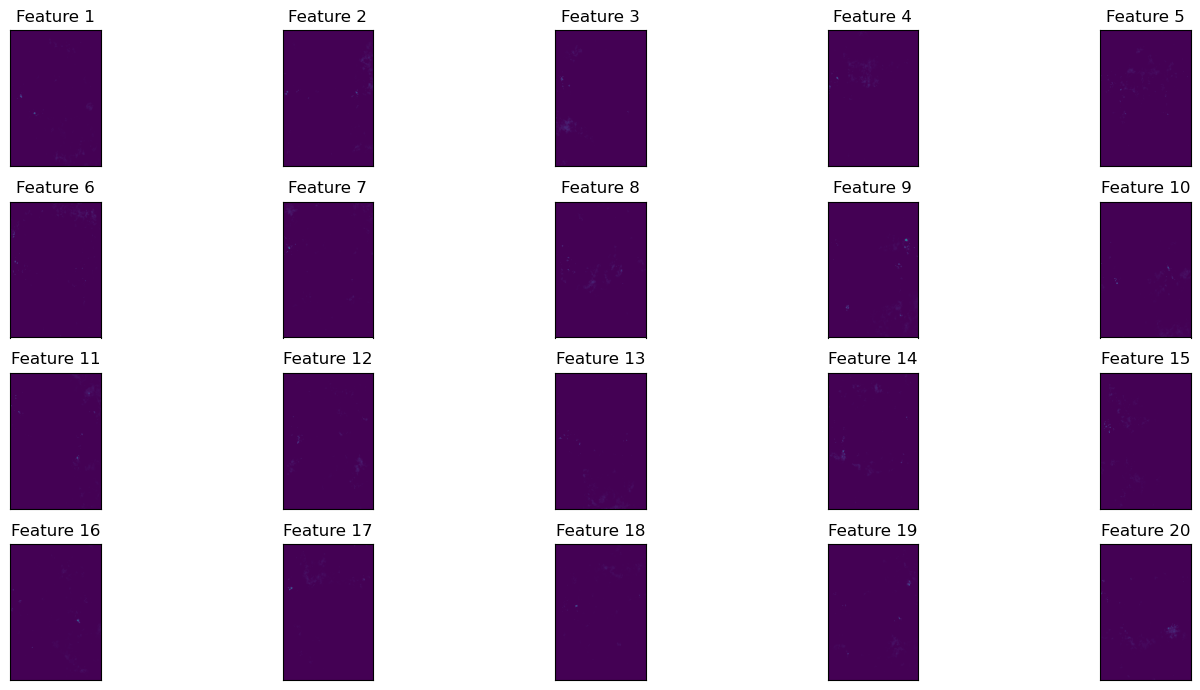

In [14]:
num_features = 20
idx = [sc[1] for sc in sorted_components[0:num_features]]

features = sparse_model.W.t()
image_components = features.reshape(features.shape[0], gray_image.shape[0], gray_image.shape[1])
image_components = image_components.detach().cpu().numpy()

top_features = image_components[idx]

fig, axes = plt.subplots(4, 5, figsize=(15, 7), subplot_kw={'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes.ravel()):
    ax.imshow(top_features[i], cmap = 'viridis')
    ax.set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

In [ ]:
# now for gpu stuff!
from torchnmf.nmf import NMF
V = torch.tensor(gray_data_flattened)


model = NMF(V.t().shape, rank=100)
print(model.W.size())
print(model.H.size())


In [ ]:
#move to the gpu
V = V.cuda()
model = model.cuda()

In [ ]:
model.fit(V.t(), tol = 0.000001, max_iter = 1000)

In [ ]:
model = model.cpu()
W = model.W.detach()
H = model.H.detach()
V = V.cpu()

In [ ]:
WH = W @ H.T

In [ ]:
from torchnmf import metrics as mt
euc = mt.euclidean(WH, V)
print(euc.item())

In [ ]:
rank15 = 47637596572.93673
rank382 = 11927036790.584213
rank382_lowtol_highmaxiter = 3550226976.273385
rank15_lt_hm = 45533987442.6467
rank383_lt_hm = 3446455585.170434
rank100_lt_hm = 24825144844.55306

print(rank15/rank382)
print(rank382/rank382_lowtol_highmaxiter) #good improvement

print(rank15/rank15_lt_hm) #not so impressive for low rank models...

print(rank382_lowtol_highmaxiter/rank383_lt_hm) #slightly better...?

print(rank382_lowtol_highmaxiter/ rank100_lt_hm) #way worse??

In [ ]:
print(H.shape)
print(W.shape)

In [ ]:
# reshape to images
features_images = np.empty((H.t().shape[0], gray_data.shape[1], gray_data.shape[2])) #number of features, image shape
for i, factor in enumerate(H.t()):
    features_images[i] = factor.reshape(gray_data.shape[1], gray_data.shape[2])

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 7), subplot_kw={'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes.ravel()):
    ax.imshow(features_images[i+25], cmap = 'gray')
    ax.set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

In [ ]:
#decompose a single image and see the reconstruction

gray_image = gray_data[4]
plt.imshow(gray_image, cmap = 'gray')
plt.show()
flat_image = gray_image.reshape(1,-1)
flat_image = torch.tensor(flat_image)
print(flat_image.shape)

In [ ]:
flat_image = flat_image.type(torch.float64)
print(flat_image.dtype)
print(model.W.dtype)
print(flat_image.shape)


In [ ]:
H.shape

In [ ]:
model2 = NMF(W, H=(flat_image.shape[0], model.H.t().shape[1]), trainable_W=False)
model2.fit(flat_image)

In [ ]:
W1 = model.forward(flat_image.type(torch.float32))

In [ ]:
# V = torch.randint(0,10,(50,50)).to(torch.float32)
# V_new = torch.randint(0,10,(1,50)).to(torch.float32)

V = torch.tensor(gray_data_flattened).to(torch.float32)
V_new = flat_image.to(torch.float32)

print(V.shape, V_new.shape)


rank = 300
model1 = NMF(V.shape, rank=rank)
V = V.cuda()
model1 = model1.cuda()
model1.fit(V, tol = 0.0000001, max_iter = 2000)
model1 = model1.cpu()
V = V.cpu()


model_new = NMF(W=model1.W.detach(), H=(V_new.shape[0], model1.H.shape[1]), trainable_W=False, rank = 400)
model_new.cuda()
V_new = V_new.cuda()
model_new.fit(V_new)

#return the gpu
V_new = V_new.cpu()
model_new = model_new.cpu()


In [ ]:
model_new.H.shape

In [ ]:
reconstructed_image = model_new.H @ model_new.W.t()
reconstructed_image.shape
reshaped_image = reconstructed_image.reshape(gray_image.shape[0], gray_image.shape[1])

fig, ax = plt.subplots(1,2)
ax[0].imshow(reshaped_image.detach().numpy(), cmap = 'gray')
ax[0].set_title('Reconstructed Image')
ax[1].imshow(gray_image, cmap = 'gray')
ax[1].set_title('Original Image')
plt.show()

In [ ]:
#what factors are used in this reconstruction?

components = model_new.H.detach().cpu()
indicies = list(range(len(components[0])))
inx_components = list(zip(components[0], indicies))

sorted_components = sorted(inx_components, key=lambda x: x[0])
sorted_components.reverse()

In [ ]:
num_features = 10
idx = [sc[1] for sc in sorted_components[0:num_features]]

features = model_new.W.t()
image_components = features.reshape(features.shape[0], gray_image.shape[0], gray_image.shape[1])
image_components = image_components.detach().cpu().numpy()

top_features = image_components[idx]

fig, axes = plt.subplots(2, 5, figsize=(15, 7), subplot_kw={'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes.ravel()):
    ax.imshow(top_features[i], cmap = 'gray')
    ax.set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()


In [ ]:
w = W1
gray_components = model.H

plt.figure(figsize=(15, 8))
num_components = gray_components.shape[0]
useful_components = np.where(w>=0.5)[1]

print(useful_components)

fig, axes = plt.subplots(1,len(useful_components), figsize=(15, 7), subplot_kw={'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes.ravel()):
    component = useful_components[i]
    ax.imshow(w[component].reshape(gray_image.shape[1], gray_image.shape[2]), cmap='gray')
    ax.set_title(f'Feature {useful_components[i]+1}')
plt.tight_layout()
plt.show()

In [ ]:
# help(model)